In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("operations_enrichies.csv", parse_dates=[0])

# Analyse bivariée : 2 variables quantitatives

In [2]:
import numpy as np

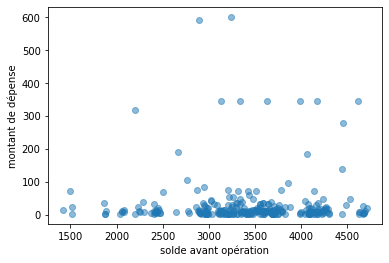

In [3]:
depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o',alpha=0.5)
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

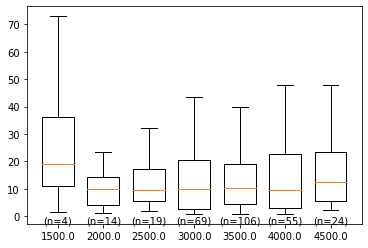

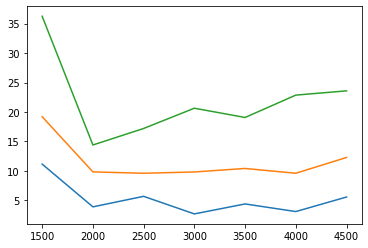

In [5]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7, # largeur graphique des boxplots
            )

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

# affichage des quartiles
for n_quartile in range(3):
    plt.plot([g["centre_classe"] for g in groupes],
             [g["quartiles"][n_quartile] for g in groupes])
plt.show()

In [6]:
import scipy.stats as st
import numpy as np

In [21]:
depenses["solde_avt_ope"]

0      1515.25
1      1513.81
2      1489.81
3      1416.81
6      2083.22
        ...   
303    2440.94
304    2436.14
305    2425.50
306    2411.92
307    2401.92
Name: solde_avt_ope, Length: 291, dtype: float64

In [7]:
st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0]

0.014536146489774601

In [8]:
np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0]

705.0942213554388

## Régression linéaire

### Calcul de la variable *attente*

In [10]:
import datetime as dt

# Selection du sous-échantillon
courses = data[data.categ == "COURSES"]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]
print(courses)
# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame([a for a in zip(a,b)])
courses.columns = ["montant","attente"]
courses

    date_operation                              libelle  montant  \
8       2023-04-05  CARTE XX XX LES ANCIENS ROBINSON XX     6.80   
13      2023-04-10  CARTE XX XX LES ANCIENS ROBINSON XX    42.42   
39      2023-04-21  CARTE XX XX L'EPICERIE DEMBAS XX XX    10.43   
43      2023-04-25  CARTE XX XX LES ANCIENS ROBINSON XX    32.67   
45      2023-04-26           CARTE XX XX LA LOUVE XX XX     1.90   
47      2023-04-28  CARTE XX XX LES ANCIENS ROBINSON XX     9.11   
53      2023-05-02             CARTE XX XX TOUPTIPRI XX    12.24   
58      2023-05-04  CARTE XX XX LES ANCIENS ROBINSON XX    17.16   
59      2023-05-05             CARTE XX XX TOUPTIPRI XX     3.48   
66      2023-05-10  CARTE XX XX LES ANCIENS ROBINSON XX    42.45   
71      2023-05-15  CARTE XX XX LES ANCIENS ROBINSON XX    33.55   
73      2023-05-15             CARTE XX XX TOUPTIPRI XX    12.96   
84      2023-05-23  CARTE XX XX LES ANCIENS ROBINSON XX     4.41   
85      2023-05-24  CARTE XX XX L'EPICERIE DEMBA

montant  attente
0     42.42        5
1     10.43       11
2     32.67        4
3      1.90        1
4      9.11        2
5     12.24        4
6     17.16        2
7      3.48        1
8     42.45        5
9     46.51        5
10     4.41        8
11    15.81        1
12    22.59        5
13     6.89        2
14    39.60       12
15     4.39        4
16    27.76        3
17    10.05        1
18    34.28        6
19    22.39        1
20    12.49        1
21     9.88       15
22     6.49        8
23    60.16        4
24     7.54        1
25     8.14        1
26    11.20        1
27    24.37        3
28     9.82        1
29    10.51        2
30    21.73        4
31     7.54        1
32    28.11        9
33    10.91        5
34    11.97        2
35    29.18        4
36    26.19        3
37    13.59        4
38    11.12        2
39     5.57        2
40     9.60        3
41    19.61        1
42    20.59        6
43     2.56        2
44    13.29        6

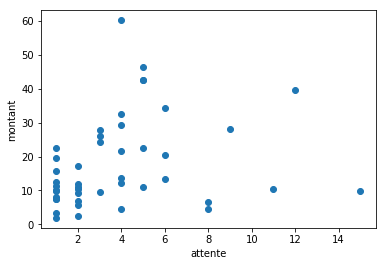

In [9]:
plt.plot(courses.attente,courses.montant, "o")
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

### Régression linéaire

In [10]:
import statsmodels.api as sm

Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

result.params

C:\Users\nedel\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


attente       1.025539
intercept    13.783470
dtype: float64

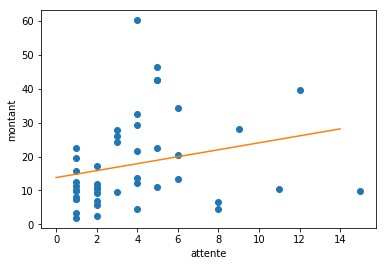

In [11]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

### Régression linéaire sans outliers

In [12]:
courses = courses[courses.attente < 15]

attente       1.702427
intercept    11.775777
dtype: float64


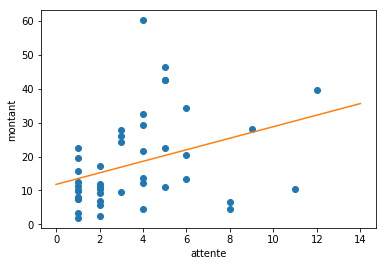

In [13]:
Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

print(result.params)

plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

# Analyse bivariée : 1 variable quantitative et 1 qualitative

In [11]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0].copy()
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER"] 

In [12]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

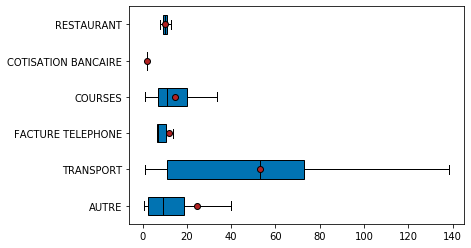

In [13]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

## ANOVA

In [14]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0]

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.3999940823368135

# Analyse bivariée : 1 variable quanti et 1 quali ?

In [15]:
X = "quart_mois"
Y = "categ"

c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data[X].value_counts()
ty = data[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data)
cont

categ       AUTRE  COTISATION BANCAIRE  COURSES  FACTURE TELEPHONE  LOYER  \
quart_mois                                                                  
1            50.0                  7.0     11.0                6.0    NaN   
2            44.0                  NaN     12.0                1.0    6.0   
3            55.0                  NaN     12.0                NaN    NaN   
4            47.0                  NaN     20.0                NaN    NaN   
total       196.0                  7.0     55.0                7.0    6.0   

categ       RESTAURANT  TRANSPORT  Total  
quart_mois                                
1                  3.0        9.0   86.0  
2                  7.0        6.0   76.0  
3                  4.0        4.0   75.0  
4                  2.0        2.0   71.0  
total             16.0       21.0  308.0

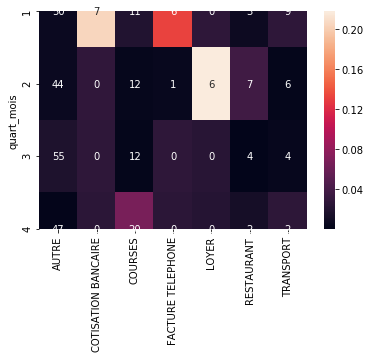

In [16]:
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(data)
indep = tx.dot(ty.T) / n

c = c.fillna(0) # on remplace les valeurs nulles par des 0
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()
sns.heatmap(mesure/xi_n,annot=c)
plt.show()

In [17]:
tx

foo
1   86
2   76
3   75
4   71

In [18]:
ty

foo
AUTRE                196
COURSES               55
TRANSPORT             21
RESTAURANT            16
COTISATION BANCAIRE    7
FACTURE TELEPHONE      7
LOYER                  6

In [19]:
indep

AUTRE    COURSES  TRANSPORT  RESTAURANT  COTISATION BANCAIRE  \
1  54.727273  15.357143   5.863636    4.467532             1.954545   
2  48.363636  13.571429   5.181818    3.948052             1.727273   
3  47.727273  13.392857   5.113636    3.896104             1.704545   
4  45.181818  12.678571   4.840909    3.688312             1.613636   

   FACTURE TELEPHONE     LOYER  
1           1.954545  1.675325  
2           1.727273  1.480519  
3           1.704545  1.461039  
4           1.613636  1.383117

In [20]:
mesure


AUTRE  COTISATION BANCAIRE   COURSES  FACTURE TELEPHONE  \
quart_mois                                                               
1           0.408336            13.024313  1.236213           8.373150   
2           0.393712             1.727273  0.181955           0.306220   
3           1.108225             1.704545  0.144857           1.704545   
4           0.073166             1.613636  4.227867           1.613636   

                LOYER  RESTAURANT  TRANSPORT  
quart_mois                                    
1            1.675325    0.482067   1.677590  
2           13.796309    2.359236   0.129187  
3            1.461039    0.002771   0.242525  
4            1.383117    0.772819   1.667200